In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, pulse
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation import MeasurementFilter
from qiskit_experiments.database_service import DbExperimentDataV1 as DbExperimentData
from qiskit_experiments.framework import ExperimentData

import calibrations

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibm_lagos')

In [3]:
config = backend.configuration()
print('Dynamic reprate', config.dynamic_reprate_enabled)
print('Rep delay:', config.rep_delay_range)
print('Default delay:', config.default_rep_delay)

Dynamic reprate True
Rep delay: [0.0, 0.0005]
Default delay: 0.00025


## What the hell is going on with qubit 3 / 5 with 3.5 / 5.3% assignment error?

In [4]:
circuits = []

circuit = QuantumCircuit(1)
circuit.measure_all()
circuits.append(circuit)

circuit = QuantumCircuit(1)
circuit.x(0)
circuit.measure_all()
circuits.append(circuit)

circuits_5 = transpile(circuits, backend=backend, initial_layout=[5], optimization_level=0)
circuits_3 = transpile(circuits, backend=backend, initial_layout=[3], optimization_level=0)

#job = backend.run(circuits_5 + circuits_3, shots=8192, meas_level=1, meas_return='single', init_qubits=False, rep_delay=0.0005)
#print(job.job_id())
#job_monitor(job)

job = backend.retrieve_job('615f1334ed29dd7297c6712b')
result = job.result()

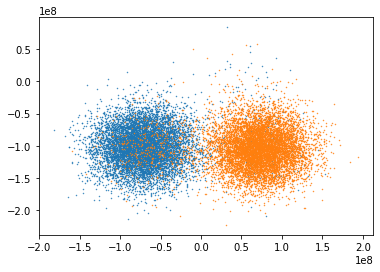

In [5]:
readout_5_0 = result.get_memory(0)[:, 0]
readout_5_1 = result.get_memory(1)[:, 0]
plt.scatter(readout_5_0.real, readout_5_0.imag, s=0.2)
plt.scatter(readout_5_1.real, readout_5_1.imag, s=0.2)

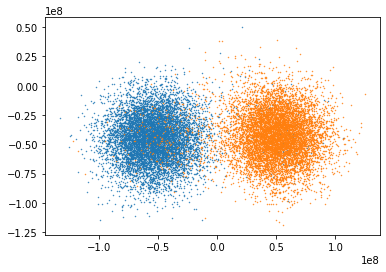

In [6]:
readout_3_0 = result.get_memory(2)[:, 0]
readout_3_1 = result.get_memory(3)[:, 0]
plt.scatter(readout_3_0.real, readout_3_0.imag, s=0.2)
plt.scatter(readout_3_1.real, readout_3_1.imag, s=0.2)

## Construct the error matrix

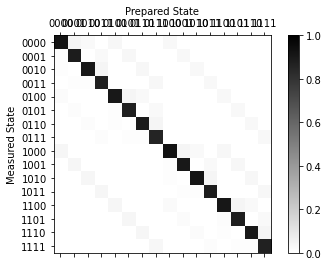

In [7]:
exp = calibrations.MeasurementErrorExperiment([1, 3, 5, 6], circuits_per_state=(900 // 16))
#exp_data = exp.run(backend=backend, shots=8192)
#exp_data.block_for_results()
#exp_data.save()

db_exp_data = DbExperimentData.load("4fa7fca0-b0d7-422f-a692-4a3fdea95de7", provider.service("experiment"))
exp_data = ExperimentData(experiment=exp, backend=backend, job_ids=db_exp_data.job_ids)

exp.run_analysis(exp_data)
exp_data.save()

## Calibrate CR

In [8]:
exp = calibrations.LinearizedCRRabiExperiment((1, 3), backend)
exp.circuits_per_point = 900 // exp.width_values.shape[0]
#exp_data = exp.run(backend=backend, shots=8192)
#exp_data.block_for_results()
#exp_data.save()

db_exp_data = DbExperimentData.load("f598cd65-7aab-4d48-b80e-16dc76ae96d1", provider.service("experiment"))
exp_data = ExperimentData(experiment=exp, backend=backend, job_ids=db_exp_data.job_ids)

exp.run_analysis(exp_data)
exp_data.save()

[  1.  44.  68.  99. 129. 145. 204. 221. 248. 283. 314. 337. 398. 409.
 445. 475. 525. 538. 578. 618. 629. 686. 702. 743. 758. 812. 817. 871.
 900. 920. 955. 977.] [0.97402082 0.96967425 0.96425084 0.95533098 0.94561332 0.93827602
 0.90452358 0.89664568 0.87297712 0.84904698 0.82381766 0.79785592
 0.73686436 0.72456578 0.6864624  0.65183803 0.59543719 0.58176095
 0.52889579 0.48074777 0.46700614 0.39911761 0.37861851 0.33241054
 0.31232561 0.2542463  0.2480338  0.19403076 0.16591971 0.14978899
 0.12241037 0.10999843] [229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376.] [0.00033214 0.00035805 0.00038766 0.00043133 0.00047351 0.00050248
 0.0006136  0.00063562 0.00069529 0.0007475  0.00079547 0.00083853
 0.00091941 0.00093277 0.00096868 0.00099469 0.00102479 0.00102994
 0.00104224 0.0

In [9]:
exp = calibrations.LinearizedCRRabiExperiment((3, 5), backend)
exp.circuits_per_point = 900 // exp.width_values.shape[0]
#exp_data = exp.run(backend=backend, shots=8192)
#exp_data.block_for_results()
#exp_data.save()

db_exp_data = DbExperimentData.load("5c038316-5d19-40b1-805f-21b3db7c1d04", provider.service("experiment"))
exp_data = ExperimentData(experiment=exp, backend=backend, job_ids=db_exp_data.job_ids)

exp.run_analysis(exp_data)
exp_data.save()

[  3.  44.  49.  80. 143. 146. 200. 235. 250. 287. 321. 366. 369. 420.
 445. 473. 503. 550. 568. 617. 641. 660. 704. 738. 763. 809. 836. 855.
 887. 930. 959. 983.] [0.95895386 0.95349121 0.95124163 0.93676322 0.8943961  0.89305769
 0.84610421 0.80737741 0.79321289 0.74746704 0.70843506 0.65387399
 0.64894758 0.57659476 0.54517909 0.50572423 0.46256365 0.3949585
 0.37016078 0.30741228 0.27434867 0.25154768 0.20456369 0.17207554
 0.14702497 0.11440604 0.10020665 0.09096418 0.0799081  0.06991141
 0.06600952 0.06685529] [229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376.] [0.00041425 0.0004397  0.00044967 0.00050819 0.0006417  0.00064527
 0.00075344 0.00082341 0.00084563 0.00090715 0.00094895 0.00099332
 0.00099659 0.00103167 0.00103972 0.00104392 0.00104106 0.00102069
 0.00100818 0.00

In [10]:
exp = calibrations.LinearizedCRRabiExperiment((5, 6), backend)
exp.circuits_per_point = 900 // exp.width_values.shape[0]
#exp_data = exp.run(backend=backend, shots=8192)
#exp_data.block_for_results()
#exp_data.save()

db_exp_data = DbExperimentData.load("2c8484ca-3ffc-49a6-800a-13229eddfcc4", provider.service("experiment"))
exp_data = ExperimentData(experiment=exp, backend=backend, job_ids=db_exp_data.job_ids)

exp.run_analysis(exp_data)
exp_data.save()

[ 14.  18.  55. 109. 138. 175. 201. 211. 248. 272. 329. 344. 371. 423.
 459. 476. 518. 546. 582. 592. 651. 679. 696. 740. 781. 792. 829. 879.
 897. 923. 952. 999.] [0.89579991 0.89430019 0.8746861  0.8301348  0.7915693  0.74682181
 0.70227923 0.68641445 0.62300328 0.58354841 0.47284372 0.44796317
 0.40113613 0.30471366 0.24023002 0.21997942 0.16030884 0.12647792
 0.09317017 0.08506557 0.05140468 0.04671805 0.04660034 0.05609131
 0.07830375 0.08824812 0.1231951  0.18450492 0.21599034 0.25163487
 0.3039638  0.38517979] [229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376. 229376.
 229376. 229376. 229376. 229376. 229376.] [0.00063792 0.00064196 0.00069128 0.00078407 0.00084811 0.00090792
 0.00095474 0.00096872 0.00101191 0.00102931 0.00104245 0.00103832
 0.00102338 0.00096107 0.00089203 0.00086491 0.00076606 0.00069402
 0.00060691 0.0